# Introduction

In this notebook we introduce [Facebook Prophet](https://facebook.github.io/prophet/). Here you get the basics for building your first model with Facebook’s advanced forecasting tool and go further exploring it.

To illustrate how Prophet works we apply it to forecast sales using the same dataset used in the last notebook where we introduced SARIMAX models.


## Facebook Prophet

[Facebook Prophet](https://github.com/facebook/prophet)  is open-source library released by [Facebook’s Core Data Science team](https://research.fb.com/category/data-science/). It is available in [R](https://cran.r-project.org/web/packages/prophet/index.html) and [Python](https://pypi.org/project/prophet/).

Prophet is a procedure for `univariate (one variable)` time series forecasting data based on an `additive model`, and the implementation supports `trends, seasonality, and holidays`. It works best with time series that have `strong seasonal effects` and `several seasons` of historical data. Prophet is `robust` to missing data and shifts in the trend, and typically handles outliers well.

It is specially interesting for new users because of its `easy use` and capacity of `find automatically a good set of hyperparameters` for  the model. Therefore, it allows users without prior knowledge or experience of forecasting time series data start using it and get reasonably good results that are often equal or sometimes even better than the ones produced by the experts.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from prophet import Prophet

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.width', None)
pd.set_option('display.max_rows', None)

In [2]:
df_store_2_item_28 = pd.read_csv("../data/processed/sales_store_2_item_28.csv")

In [3]:
df_store_2_item_28.head()

,date,sales
0,2013-01-01,12
1,2013-01-02,16
2,2013-01-03,16
3,2013-01-04,20
4,2013-01-05,16


In [4]:
df_store_2_item_28.tail()

,date,sales
1821,2017-12-27,19
1822,2017-12-28,21
1823,2017-12-29,18
1824,2017-12-30,24
1825,2017-12-31,31


In [5]:
df_store_2_item_28.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    1826 non-null   object
 1   sales   1826 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 28.7+ KB


# Visualize times series sales of item 28 at store 2

In [6]:
# select item 28 and keep only column sales
df_store_2_item_28['date']=pd.to_datetime(df_store_2_item_28['date'])
df_store_2_item_28_time = df_store_2_item_28.set_index('date')
df_store_2_item_28_time.head()

,sales
date,
2013-01-01,12
2013-01-02,16
2013-01-03,16
2013-01-04,20
2013-01-05,16


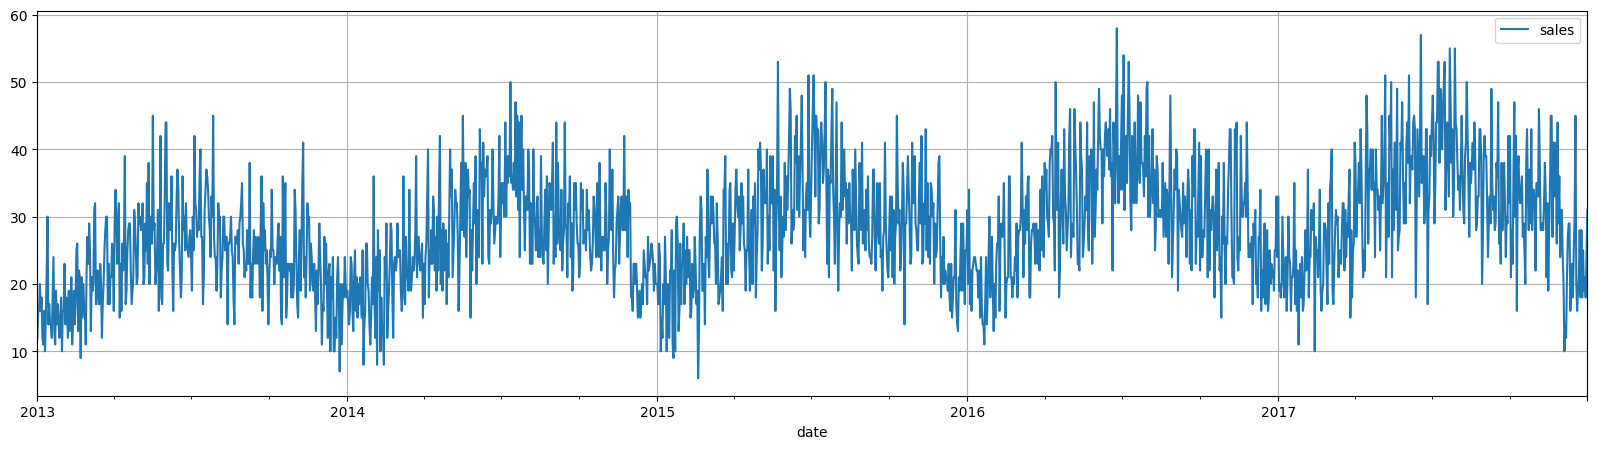

In [7]:
# Plot the entire time series diet and show gridlines
df_store_2_item_28_time.plot(grid=True,figsize=(20,5))
plt.show()

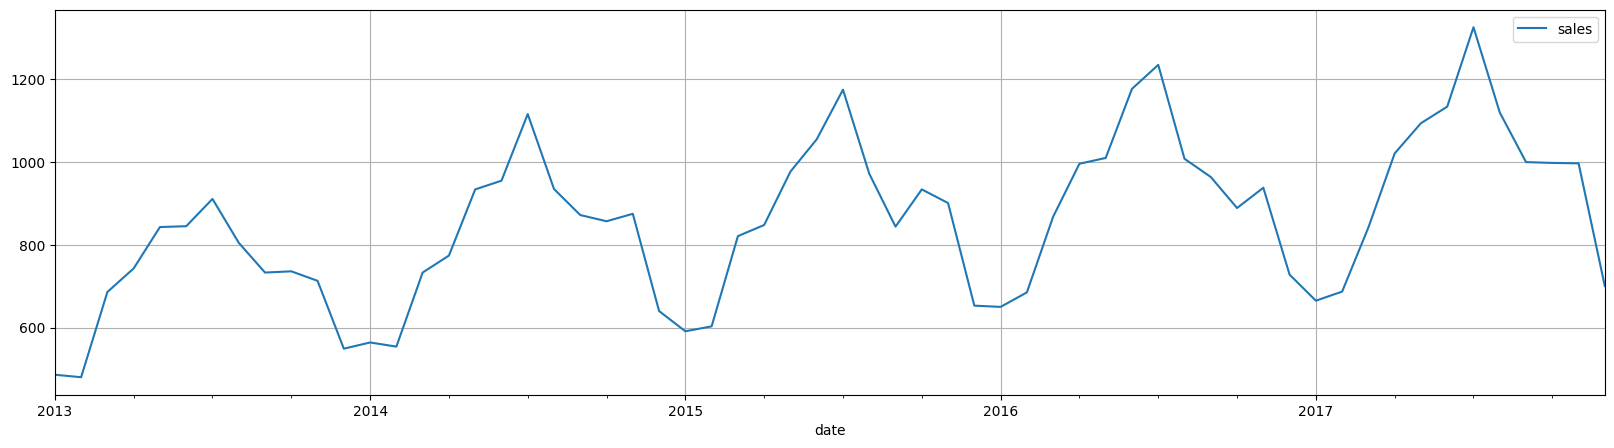

In [8]:
# Plot the entire time series diet and show gridlines
df_store_2_item_28_time.resample('M').sum().plot(grid=True,figsize=(20,5))
plt.show()

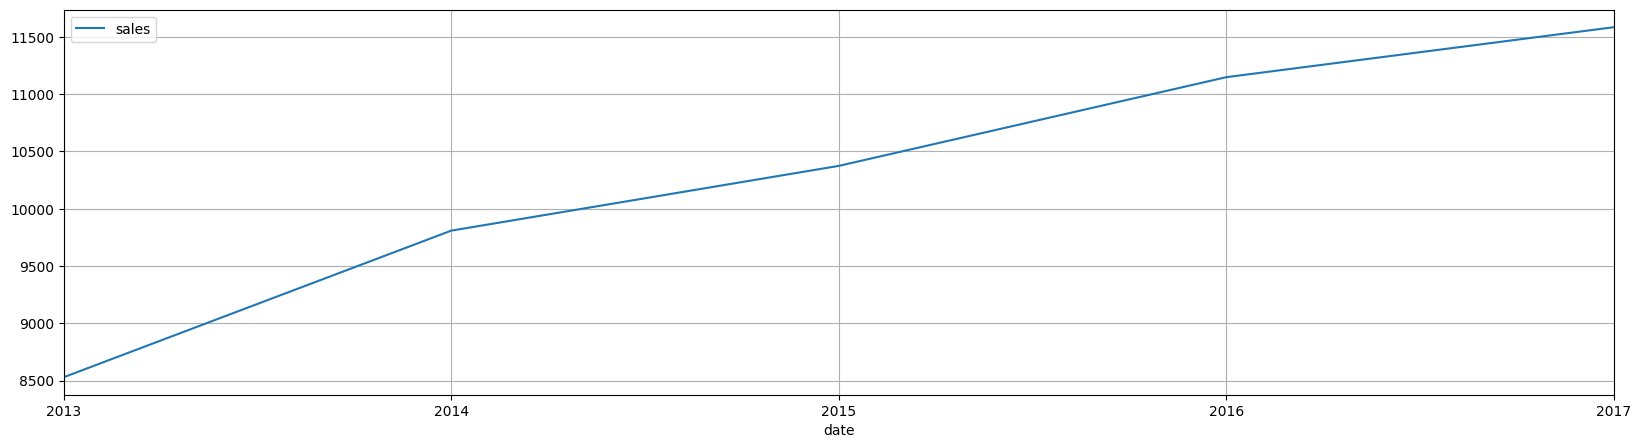

In [9]:
df_store_2_item_28_time.resample('A').sum().plot(grid=True,figsize=(20,5))
plt.show()

### 📉 Seasonal Decomposition of Time Series

This block performs seasonal decomposition on the time series `df_store_2_item_28_time` using the **additive model** and a seasonal `period=365` (e.g., for daily data with yearly seasonality).

Key steps:

- `rcParams['figure.figsize'] = (11, 9)`: sets the default plot size.
- `sm.tsa.seasonal_decompose(...)`: decomposes the time series into **trend**, **seasonal**, and **residual** components.
- `model='additive'`: assumes the time series follows an additive relationship:  
  `observed = trend + seasonal + residual`
- `period=365`: tells the model that seasonality repeats every 365 observations.
- `decomposition.plot()`: creates a plot showing the original time series along with its trend, seasonal, and residual components.
- `plt.show()`: displays the plot.

This is useful for understanding the underlying patterns in a time series before modeling.


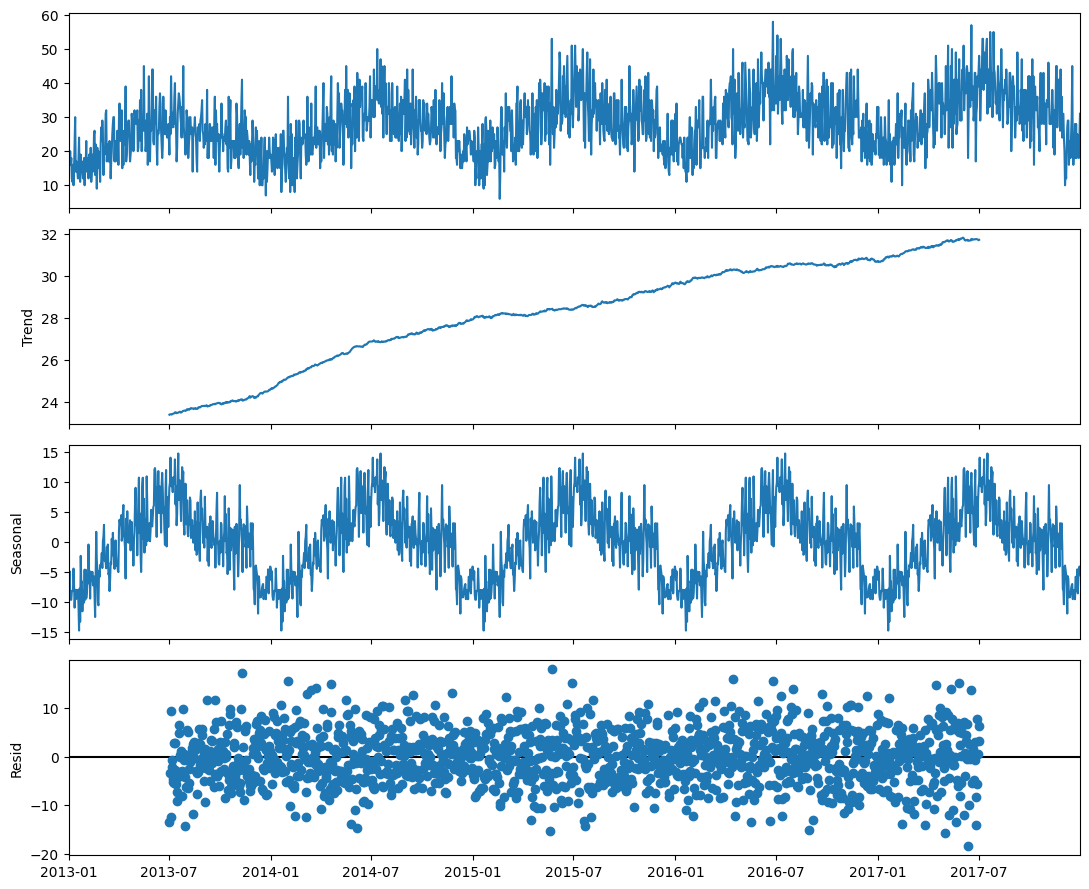

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9
decomposition = sm.tsa.seasonal_decompose(df_store_2_item_28_time, 
                                         model = 'additive',
                                         period=365) 
fig = decomposition.plot()
plt.show()

### 🔍 How `seasonal_decompose` Works (Key Concepts)

This method breaks down a time series into three components:

- **Trend (T)** – Long-term movement in the data (e.g., growth or decline)
- **Seasonal (S)** – Repeating short-term pattern (e.g., yearly, weekly)
- **Residual (R)** – What's left after removing trend and seasonality (i.e., noise)

Depending on the model:

- **Additive**:  
  `Y(t) = T(t) + S(t) + R(t)`

- **Multiplicative**:  
  `Y(t) = T(t) * S(t) * R(t)`

---

### ⚙️ What Happens Step-by-Step (Additive Model):

1. **Trend estimation** – Uses a centered moving average over the seasonal period (e.g., 365 days)
2. **Detrending** – Subtract trend from the original series:  
   `Detrended(t) = Y(t) - T(t)`
3. **Seasonal component** – Computed by averaging values at the same seasonal positions (e.g., all Mondays, all Januaries)
4. **Residual** – What's left after removing trend and seasonal parts:  
   `R(t) = Y(t) - T(t) - S(t)`

---

### ⚠️ Limitations

- Assumes fixed seasonality (`period` must be known)
- Not suitable for multiple or changing seasonal patterns
- Sensitive to missing values and outliers

📌 For more flexible decomposition, consider using `STL`, `Prophet`, or `TBATS`.


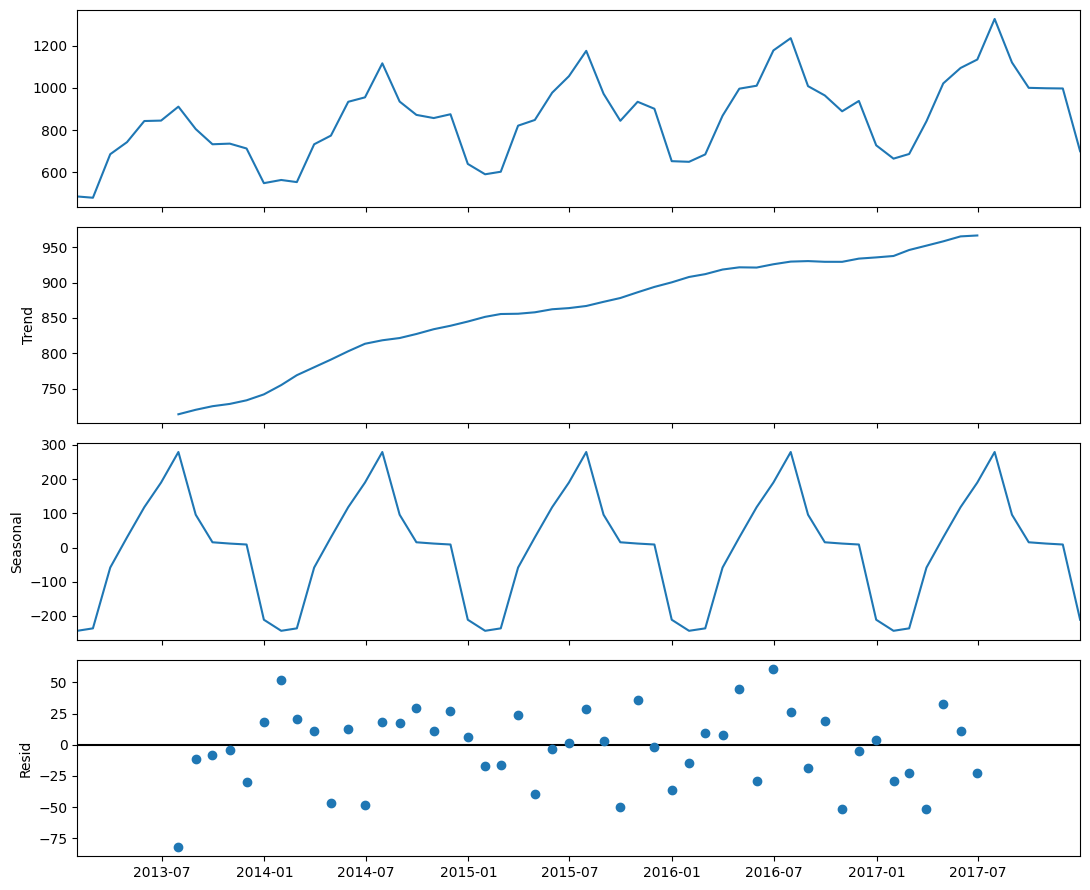

In [11]:
decomposition = sm.tsa.seasonal_decompose(df_store_2_item_28_time.resample('M').sum(), 
                                          model = 'additive',
                                         period=12) 
fig = decomposition.plot()
plt.show()

From the decomposition above we can conclude:

1. There is a `upward trend` on sales, i.e., our time series is `not stationary`.
2. From the seasonal component we can observe that the model is `additive`, since the seasonal component is similar (not getting multiplied) over the period of time.
3. Also we can observe on the seasonal component `seasonality` in sales with lower sales in January and higher sales in July.


# Forecasting with Facebook Prophet

## Prepare Data for Prophet

Prophet requires as input a dataframe with two columns:

* `ds`: datetime column
* `y`: numeric column which represents the measurement we wish to forecast.

Our data is almost ready. We just need to rename columns `date` and `sales`, respectively, as `ds` and `y`.

In [13]:
# rename date and sales, respectively ds and y
df_store_2_item_28.columns = ['ds','y']
df_store_2_item_28.head()

,ds,y
0,2013-01-01,12
1,2013-01-02,16
2,2013-01-03,16
3,2013-01-04,20
4,2013-01-05,16


In [14]:
df_store_2_item_28.tail()

,ds,y
1821,2017-12-27,19
1822,2017-12-28,21
1823,2017-12-29,18
1824,2017-12-30,24
1825,2017-12-31,31


## Train Model

To train a model in Prophet, first we create an instance of the model class and then we call the fit method. 

In principle, you don't need to specify any hyparameters. One important exception is `seasonality_mode`. It is important to set this parameter to `multiplicative` if your model is multiplicative since Prophet is based on an additive model. As we saw previously, the seasonality in our model follows an additive behavior. Therefore, there is no need to set `seasonality_mode` as multiplicative.


Although Prophet is able to find automatically a good set of hyperparameters, we will see later that some fine tuning can improve performance. Specially, applying your knowledge of the business case might make a huge difference even if Prophet has the power of handling many things by itself.

Just to exemplify, I'll include the parameter `interval_width` that sets the confidence interval. 

To know more about how to tweak those parameters in your favor check [Prophet documentation](https://facebook.github.io/prophet/docs/quick_start.html).


In [15]:
m = Prophet(interval_width=0.95) #by default is 80%
model = m.fit(df_store_2_item_28)

21:02:19 - cmdstanpy - INFO - Chain [1] start processing
21:02:19 - cmdstanpy - INFO - Chain [1] done processing


## Forecast

In order to forecast we first need to create a dataframe that will save our predictions. Method `make_future_dataframe` builds a dataframe that extends into the future a specified number of days. In our case, we will predict 90 days into the future. 

By default the dataframe created includes the dates from the history, so we see the model fit as well.

In [16]:
future = m.make_future_dataframe(periods=90) 
future.head()

,ds
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05


In [17]:
future.tail()

,ds
1911,2018-03-27
1912,2018-03-28
1913,2018-03-29
1914,2018-03-30
1915,2018-03-31


In [18]:
df_store_2_item_28.tail()

,ds,y
1821,2017-12-27,19
1822,2017-12-28,21
1823,2017-12-29,18
1824,2017-12-30,24
1825,2017-12-31,31


### Forecast Dataframe

In [19]:
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,22.236330,2.155657,23.015526,22.236330,22.236330,-9.684195,-9.684195,-9.684195,-2.316632,-2.316632,-2.316632,-7.367563,-7.367563,-7.367563,0.0,0.0,0.0,12.552135
1,2013-01-02,22.244089,1.051153,22.278787,22.244089,22.244089,-10.080468,-10.080468,-10.080468,-2.724683,-2.724683,-2.724683,-7.355785,-7.355785,-7.355785,0.0,0.0,0.0,12.163621
2,2013-01-03,22.251848,5.029141,24.869265,22.251848,22.251848,-7.527774,-7.527774,-7.527774,-0.167203,-0.167203,-0.167203,-7.360571,-7.360571,-7.360571,0.0,0.0,0.0,14.724075
3,2013-01-04,22.259607,7.165775,27.793060,22.259607,22.259607,-5.071312,-5.071312,-5.071312,2.309825,2.309825,2.309825,-7.381138,-7.381138,-7.381138,0.0,0.0,0.0,17.188295
4,2013-01-05,22.267366,7.666580,28.702696,22.267366,22.267366,-3.660118,-3.660118,-3.660118,3.756208,3.756208,3.756208,-7.416326,-7.416326,-7.416326,0.0,0.0,0.0,18.607249


The `forecast dataframe` contains Prophet’s prediction for sales. Because we've also passed historical dates, it provides an in-sample fit that we can use to evaluate our model.

As you can see, `forecast` includes a column `yhat` with the forecast, as well as columns for components and uncertainty intervals.

### Forecast Plot

To plot the forecast you just need to call method `.plot()` on your forecast dataframe.

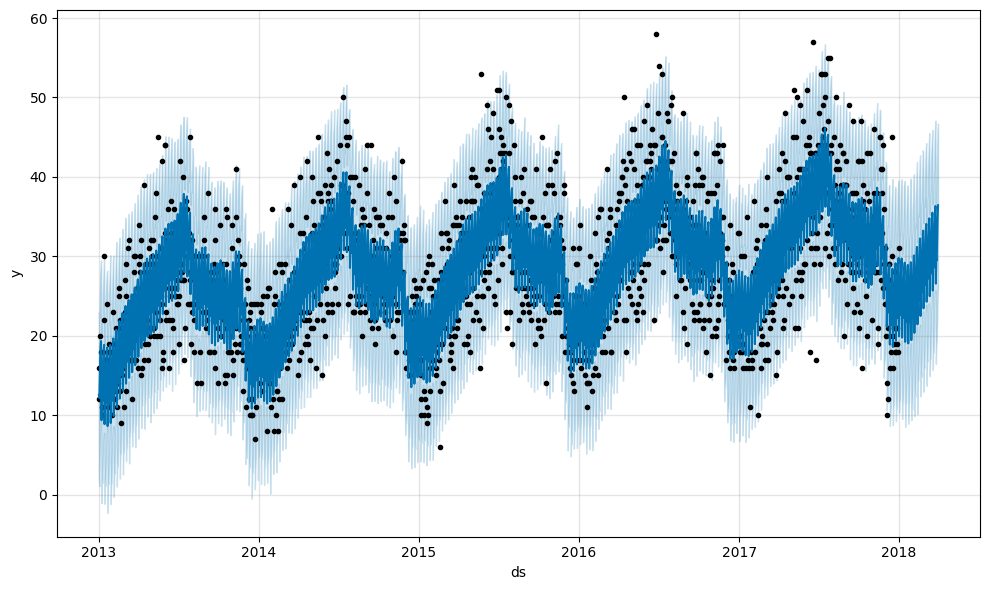

In [20]:
plot1 = m.plot(forecast)

### 📈 Forecast Plot Interpretation

In the forecast plot above:

- **Deep blue line**: Forecasted sales (`forecast['yhat']`)
- **Black dots**: Actual historical sales data (`forecast['y']`)
- **Light blue shaded area**: 95% confidence interval around the forecast  
  - Lower bound: `forecast['yhat_lower']`
  - Upper bound: `forecast['yhat_upper']`

This visual provides a clear picture of how well the model fits the historical data and how confident it is in future predictions.

---

### ⚡ Trend Changepoints

Real-world time series often experience **sudden shifts** in behavior due to events like product launches, economic changes, or external shocks. Prophet refers to these shifts as **changepoints**.

At changepoints:
- The model allows the **growth rate of the trend** to change
- This makes the model **flexible** enough to handle structural changes in the time series

However, more flexibility can lead to:
- **Overfitting** (too many changes, too reactive)
- **Underfitting** (not reactive enough to true changes)

#### 🔧 Controlling Trend Flexibility

- **`changepoint_prior_scale`**:  
  Adjusts how flexible the model is when detecting changepoints.  
  - Larger values = more flexible trend  
  - Smaller values = smoother, more conservative trend  

- **`changepoint_range`**:  
  By default, Prophet only looks for changepoints in the **first 80%** of the time series. You can change this (e.g., to include recent shifts) by setting the `changepoint_range` argument.

- **`changepoints`**:  
  You can also **manually specify** changepoints by passing a list of dates to this parameter.

---

In the plot below, **vertical dotted lines** represent the automatically detected changepoints.

For more in-depth details on changepoints in Prophet, check out the [official docs](https://facebook.github.io/prophet/docs/trend_changepoints.html).


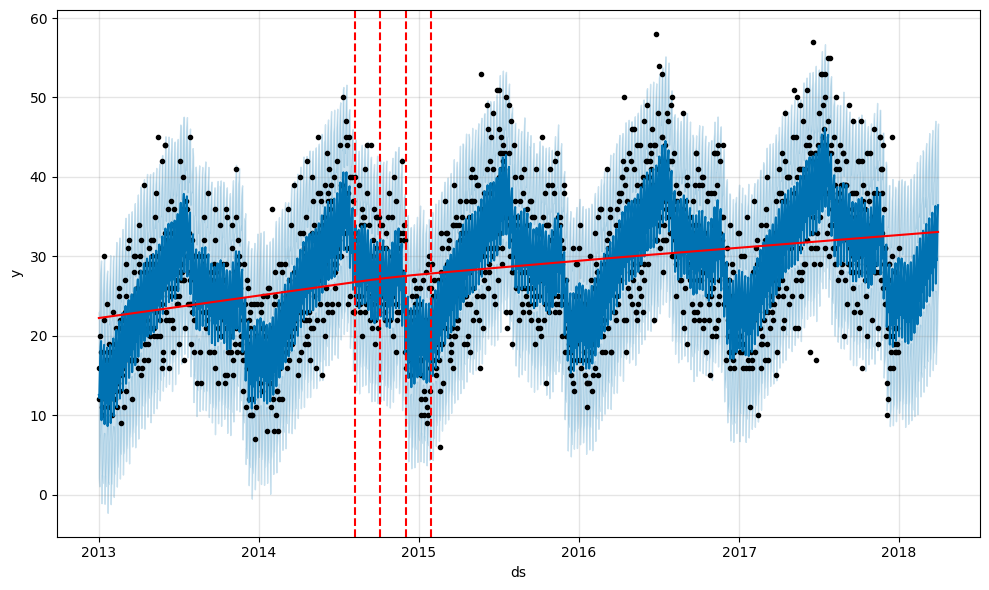

In [23]:
from prophet.plot import add_changepoints_to_plot

plot1 = m.plot(forecast)
a = add_changepoints_to_plot(plot1.gca(),m,forecast)

## 📦 Prophet Model — Components with Intuition and Mathematical Structure

Prophet models a time series as the sum of four components:

$$
y(t) = g(t) + s(t) + h(t) + \varepsilon(t)
$$

Where:
- $g(t)$: trend
- $s(t)$: seasonality
- $h(t)$: holiday effects
- $\varepsilon(t)$: random noise (error)

---

### 📈 1. Trend Component — $g(t)$

**Purpose:** Models the long-term trajectory of the time series.

Prophet supports:
- **Linear growth**: constant rate of change
- **Logistic growth**: growth that slows toward a maximum (saturates)
- **Piecewise-linear**: automatically detects changepoints where the trend can change

In the piecewise-linear case:

$$
g(t) = k t + m + \sum_{j=1}^{S} \delta_j D_j(t)
$$

Where:
- $k$ is the initial slope (growth rate)  
- $m$ is the intercept  
- $D_j(t)$ is 1 if $t$ is after changepoint $j$, 0 otherwise  
- $\delta_j$ is the change in slope at changepoint $j$

**Controls:**
- `changepoint_prior_scale` adjusts how flexible the trend is

---

### 🔁 2. Seasonality Component — $s(t)$

**Purpose:** Captures repeating cycles (e.g. weekly, yearly patterns)

Prophet uses a **Fourier series**:

$$
s(t) = \sum_{n=1}^{N} \left[ a_n \cos\left( \frac{2\pi n t}{P} \right) + b_n \sin\left( \frac{2\pi n t}{P} \right) \right]
$$

Where:
- $P$ is the period (e.g. 365.25 for yearly seasonality)
- $N$ is the number of Fourier terms
- $a_n$, $b_n$ are coefficients learned from data

**Controls:**
- `seasonality_prior_scale` adjusts how strongly Prophet fits the seasonal pattern

---

### 📅 3. Holiday Effects — $h(t)$

**Purpose:** Captures known one-time or recurring effects (e.g. Black Friday)

Prophet models holidays using indicator variables:

$$
h(t) = \sum_{j=1}^{H} \lambda_j Z_j(t)
$$

Where:
- $Z_j(t)$ is 1 if time $t$ matches holiday $j$
- $\lambda_j$ is the effect size of that holiday

You can use built-in country holidays or define custom ones.

---

### 🎲 4. Error / Noise — $\varepsilon(t)$

**Purpose:** Captures irregular, unpredictable variation.

Prophet does not model this directly but includes it as part of the confidence interval around the forecast.

---

### 🧠 Summary Equation:

$$
y(t) = g(t) + s(t) + h(t) + \varepsilon(t)
$$

Prophet builds interpretable forecasts by modeling each component separately and summing them together.


### 🔁 Prophet vs SARIMAX (Comparison)

| Feature                | Prophet                               | SARIMAX                                |
|------------------------|----------------------------------------|----------------------------------------|
| Trend modeling         | Automatically detects changepoints     | Modeled manually with AR/MA terms       |
| Seasonality            | Uses Fourier series                    | Uses seasonal ARIMA terms (P, D, Q)     |
| Holidays support       | Built-in and easy to configure         | Requires manual feature engineering     |
| Handles missing data   | Yes                                    | No (must be imputed)                    |
| Robust to outliers     | Yes (more forgiving)                   | No (sensitive to anomalies)             |
| Interpretability       | High (modular components)              | Moderate (statistical coefficients)     |
| Ease of use            | Beginner-friendly                      | Requires experience & tuning            |

---

Prophet is ideal for quickly building reliable forecasts on time series data with minimal tuning. It's not always the most accurate in complex cases, but it's interpretable, robust, and very easy to use. SARIMAX offers more control but comes with a steeper learning curve and more manual tuning.

## Evaluate model

How this model is performing?

The forecast dataframe includes predictions made on the training data dates. Therefore, we can use this in-sample fit to evaluate our model.

In [24]:
df_merge = pd.merge(df_store_2_item_28, forecast[['ds','yhat_lower','yhat_upper','yhat']],on='ds')
df_merge = df_merge[['ds','yhat_lower','yhat_upper','yhat','y']]
df_merge.head()

,ds,yhat_lower,yhat_upper,yhat,y
0,2013-01-01,2.155657,23.015526,12.552135,12
1,2013-01-02,1.051153,22.278787,12.163621,16
2,2013-01-03,5.029141,24.869265,14.724075,16
3,2013-01-04,7.165775,27.793060,17.188295,20
4,2013-01-05,7.666580,28.702696,18.607249,16


In [25]:
df_merge.tail()

,ds,yhat_lower,yhat_upper,yhat,y
1821,2017-12-27,10.879610,32.663375,22.242066,19
1822,2017-12-28,14.430927,35.250283,24.897818,21
1823,2017-12-29,16.934379,37.730546,27.459887,18
1824,2017-12-30,18.626166,39.209246,28.976415,24
1825,2017-12-31,19.484997,39.551335,29.798729,31


To evaluate this model we will be using `MAE` and `MAPE`, as done previously for the SARIMAX models. Like this, we can compare and find out which model is the best model.

In [26]:
# calculate MAE between observed and predicted values 
y_true = df_merge['y'].values
y_pred = df_merge['yhat'].values
mae_01 = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae_01)

MAE: 4.275


In [27]:
mape_01 = mean_absolute_percentage_error(y_true, y_pred)
print('MAPE: %.3f' % mape_01)

MAPE: 0.169


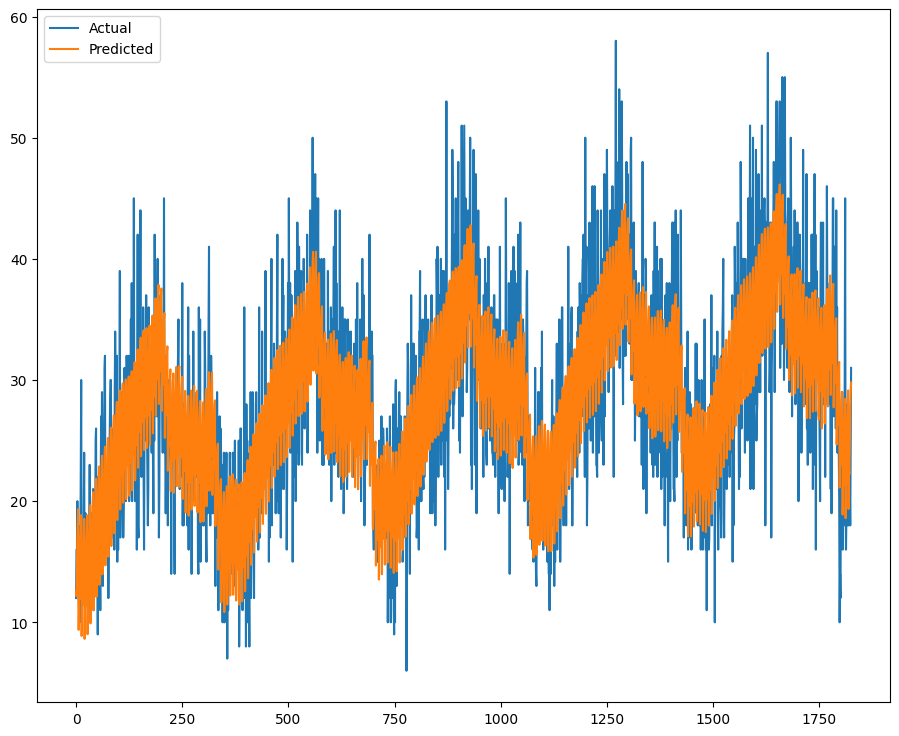

In [28]:
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()


### Prophet's Diagnostic Tools

As part of the evaluation process we can make good use of some [diagnostic tools provided by Prophet](https://facebook.github.io/prophet/docs/diagnostics.html), such as `Cross Validation` and `Hyperparameter tuning`.

#### Cross Validation

Prophet includes functionality for time series [cross validation](https://facebook.github.io/prophet/docs/diagnostics.html#cross-validation) to measure forecast error by comparing the predicted values with the actual values.

To apply the `cross_validation` function, we specify the forecast horizon (`horizon`), then optionally the size of the initial training period (`initial`) and the spacing between cutoff dates (`period`).

In [29]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, horizon='90 days')
# df_cv = cross_validation(m, initial='270 days', period='45 days', horizon = '90 days')
df_cv.head()

  0%|          | 0/31 [00:00<?, ?it/s]

21:37:12 - cmdstanpy - INFO - Chain [1] start processing
21:37:12 - cmdstanpy - INFO - Chain [1] done processing
21:37:12 - cmdstanpy - INFO - Chain [1] start processing
21:37:12 - cmdstanpy - INFO - Chain [1] done processing
21:37:12 - cmdstanpy - INFO - Chain [1] start processing
21:37:12 - cmdstanpy - INFO - Chain [1] done processing
21:37:13 - cmdstanpy - INFO - Chain [1] start processing
21:37:13 - cmdstanpy - INFO - Chain [1] done processing
21:37:13 - cmdstanpy - INFO - Chain [1] start processing
21:37:13 - cmdstanpy - INFO - Chain [1] done processing
21:37:13 - cmdstanpy - INFO - Chain [1] start processing
21:37:13 - cmdstanpy - INFO - Chain [1] done processing
21:37:13 - cmdstanpy - INFO - Chain [1] start processing
21:37:13 - cmdstanpy - INFO - Chain [1] done processing
21:37:13 - cmdstanpy - INFO - Chain [1] start processing
21:37:13 - cmdstanpy - INFO - Chain [1] done processing
21:37:13 - cmdstanpy - INFO - Chain [1] start processing
21:37:13 - cmdstanpy - INFO - Chain [1]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-01-22,16.278299,7.114680,25.003136,16,2014-01-21
1,2014-01-23,18.260341,8.770972,27.724977,26,2014-01-21
2,2014-01-24,20.096475,10.850656,28.232079,26,2014-01-21
3,2014-01-25,20.280620,11.536777,29.505798,20,2014-01-21
4,2014-01-26,21.125894,11.910493,30.209240,19,2014-01-21


In [30]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
2785,2017-12-27,22.969552,12.114234,33.910666,19,2017-10-02
2786,2017-12-28,25.530872,15.802315,35.856686,21,2017-10-02
2787,2017-12-29,28.042392,17.046889,38.648866,18,2017-10-02
2788,2017-12-30,29.555403,19.060309,39.713011,24,2017-10-02
2789,2017-12-31,30.230522,18.847223,40.162994,31,2017-10-02


In [31]:
from prophet.diagnostics import performance_metrics

df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,9 days,34.865558,5.904706,4.820040,0.182380,0.139414,0.169393,0.910394
1,10 days,34.931844,5.910317,4.818810,0.185902,0.142469,0.171094,0.910394
2,11 days,35.995521,5.999627,4.843341,0.187544,0.141675,0.172096,0.896057
3,12 days,35.054919,5.920719,4.745814,0.183080,0.136627,0.168208,0.892473
4,13 days,32.291588,5.682569,4.550072,0.178454,0.129027,0.162578,0.910394


In [32]:
df_p.tail()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
77,86 days,34.030677,5.833582,4.652173,0.185011,0.132557,0.164445,0.910394
78,87 days,32.409428,5.692928,4.530012,0.172869,0.130763,0.157983,0.910394
79,88 days,31.629740,5.624032,4.543139,0.168524,0.132557,0.156428,0.917563
80,89 days,32.744025,5.722240,4.638729,0.172194,0.132249,0.158959,0.910394
81,90 days,33.129617,5.755833,4.706035,0.171994,0.140039,0.159780,0.913978
